## Linear Regression

Linear regression may be a good model for some of the data but there is a good chance that it will not model the spatial data (X, Y) well. This would require something such as decision trees or a neural network. Regardless, we will see how the linear regression goes. First we will import the relevant libraries and data.

In [18]:
### importing libraries ###

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

In [2]:
### importing data ###

# features
features_train = pd.read_csv('data/features_train.csv', index_col = 0)
features_test = pd.read_csv('data/features_test.csv', index_col = 0)

# target
target_train = pd.read_csv('data/target_train.csv', index_col = 0)
target_test = pd.read_csv('data/target_test.csv', index_col = 0)

Let's first check to see how a linear regression model performs without any tuning.

In [3]:
### linear regression function ###

def run_model():
    
    model = LinearRegression().fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print('For the train set the r2 is:', r2_score(target_train, pred_train), 
          'and the RMSE is:', mean_squared_error(target_train, pred_train, squared = False))

    print('For the test set the r2 is:', r2_score(target_test, pred_test), 
          'and the RMSE is:', mean_squared_error(target_test, pred_test, squared = False))
    

run_model()

For the train set the r2 is: 0.03611919838796995 and the RMSE is: 0.9854976751299134
For the test set the r2 is: -0.04660620219887046 and the RMSE is: 1.0230377325391622


The r2 and RMSE values are quite poor for the base dataset. Let's see if we can improve this somehow. First let's look at correlations.

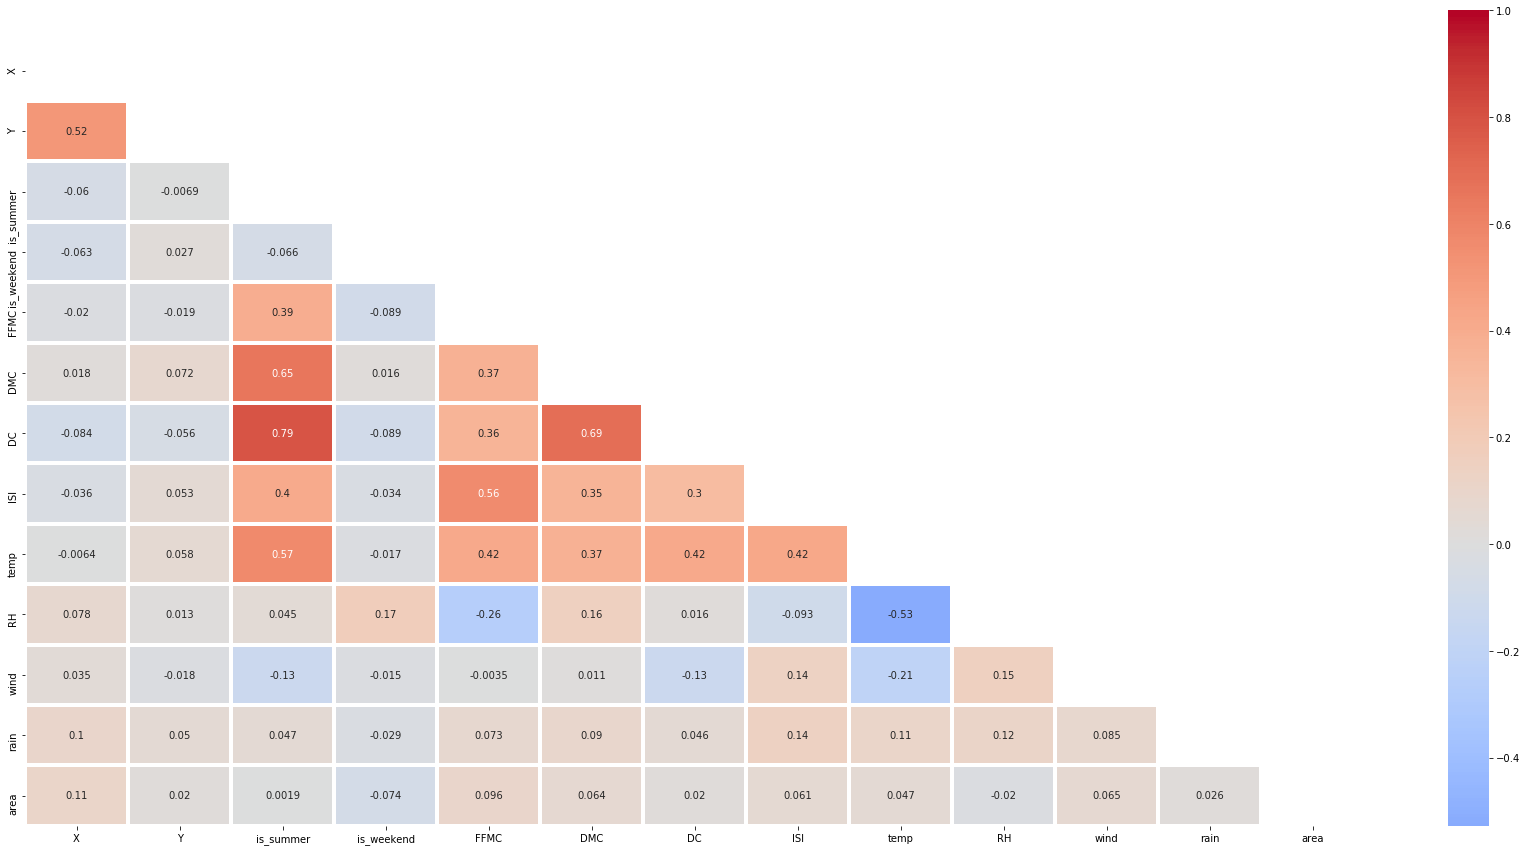

In [4]:
### checking correlations ###

# correlation matrix function
def create_corr():
    
    # creating correlation matrix
    train_joined = features_train.join(target_train)
    corr_mat = train_joined.corr()

    # mask
    mask = np.zeros_like(corr_mat, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True

    # plotting heat map
    plt.figure(figsize=(30, 15))
    sns.heatmap(corr_mat,cmap='coolwarm', center=0,annot=True, linewidths= 3, mask=mask)
    plt.ylim(len(train_joined.columns),-0.5, -0.5)
    plt.show()

create_corr()

We see that area does not have a strong correlation with any variable. We do see potential multicollinearity however with X and Y, DC and both DMC and is_summer, etc. We will deal with multicollinearity later but for now, let's see if we can improve correlations with area. First, we will visualize the relationships between the features and target to see if there is a nonlinear relationship. 

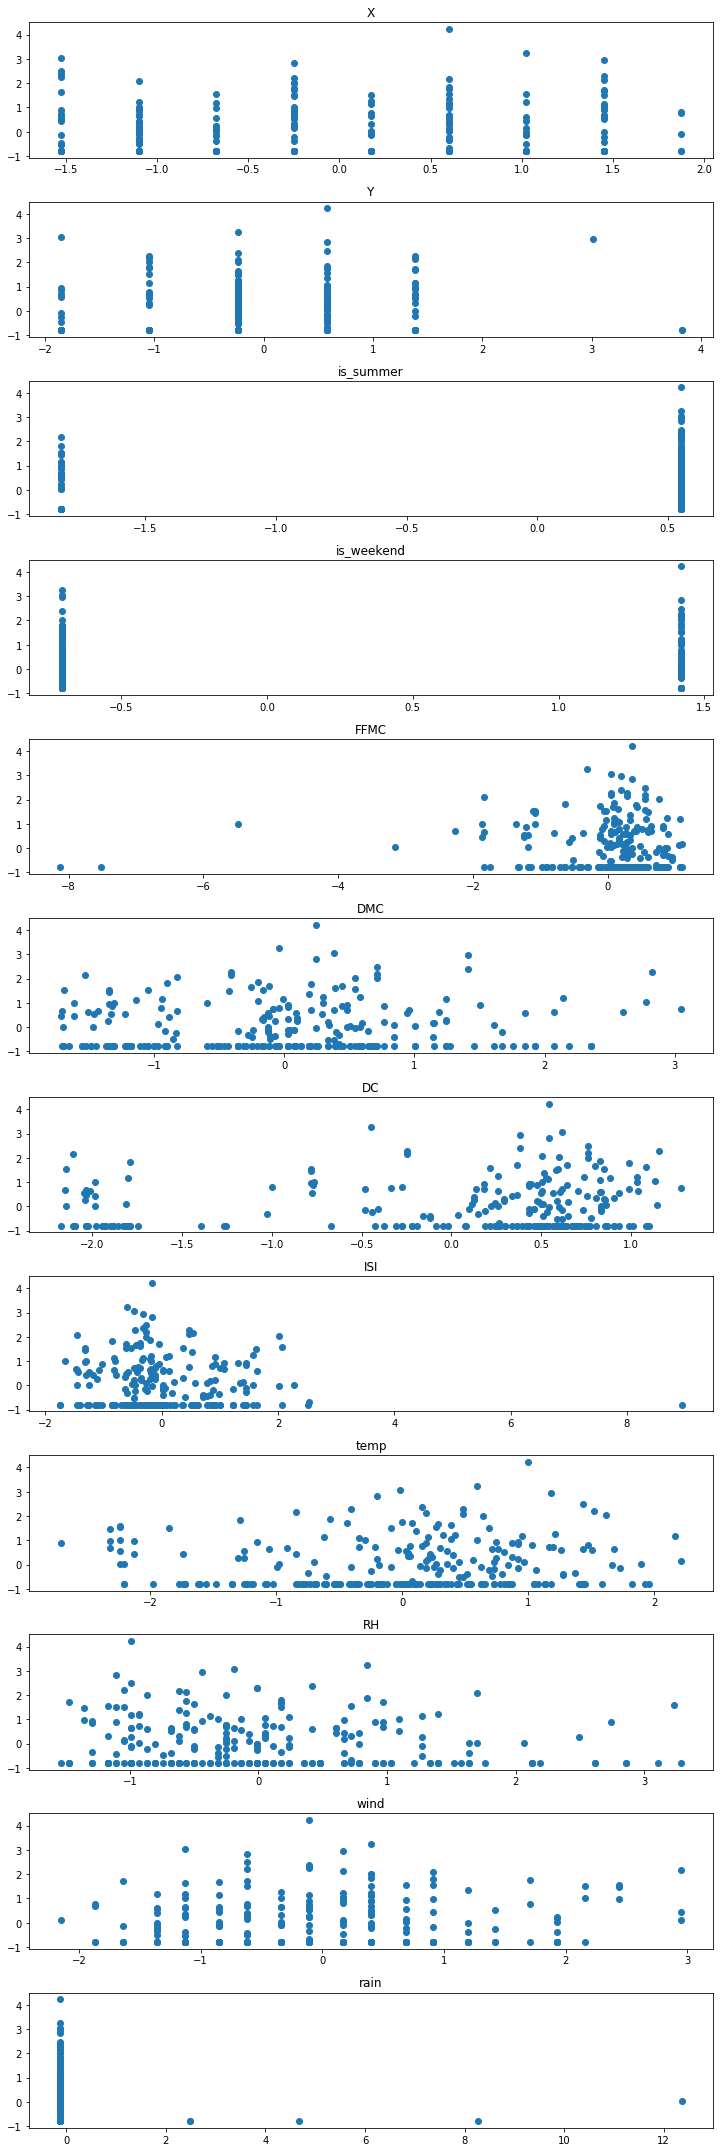

In [5]:
### scatterplots ###

# subplots
fig, ax = plt.subplots(12, figsize = (10, 30))

# initial index
index = 0

# scatterplots
for column in features_test.columns:
    ax[index].scatter(x = features_test[column], y = target_test)
    ax[index].title.set_text(column)
    index += 1
    
plt.tight_layout()

From what we can see, it appears that wind may have a quadratic relationship. Rain seems to have only 4 values that are different from the majority. We will transform wind data to try to better capture its relationship with area.

In [6]:
### accounting for quadratic relationship ###

features_train['wind'] = features_train['wind'].apply(lambda x: (x + 3) ** 0.5)
features_test['wind'] = features_test['wind'].apply(lambda x: (x + 3) ** 0.5)

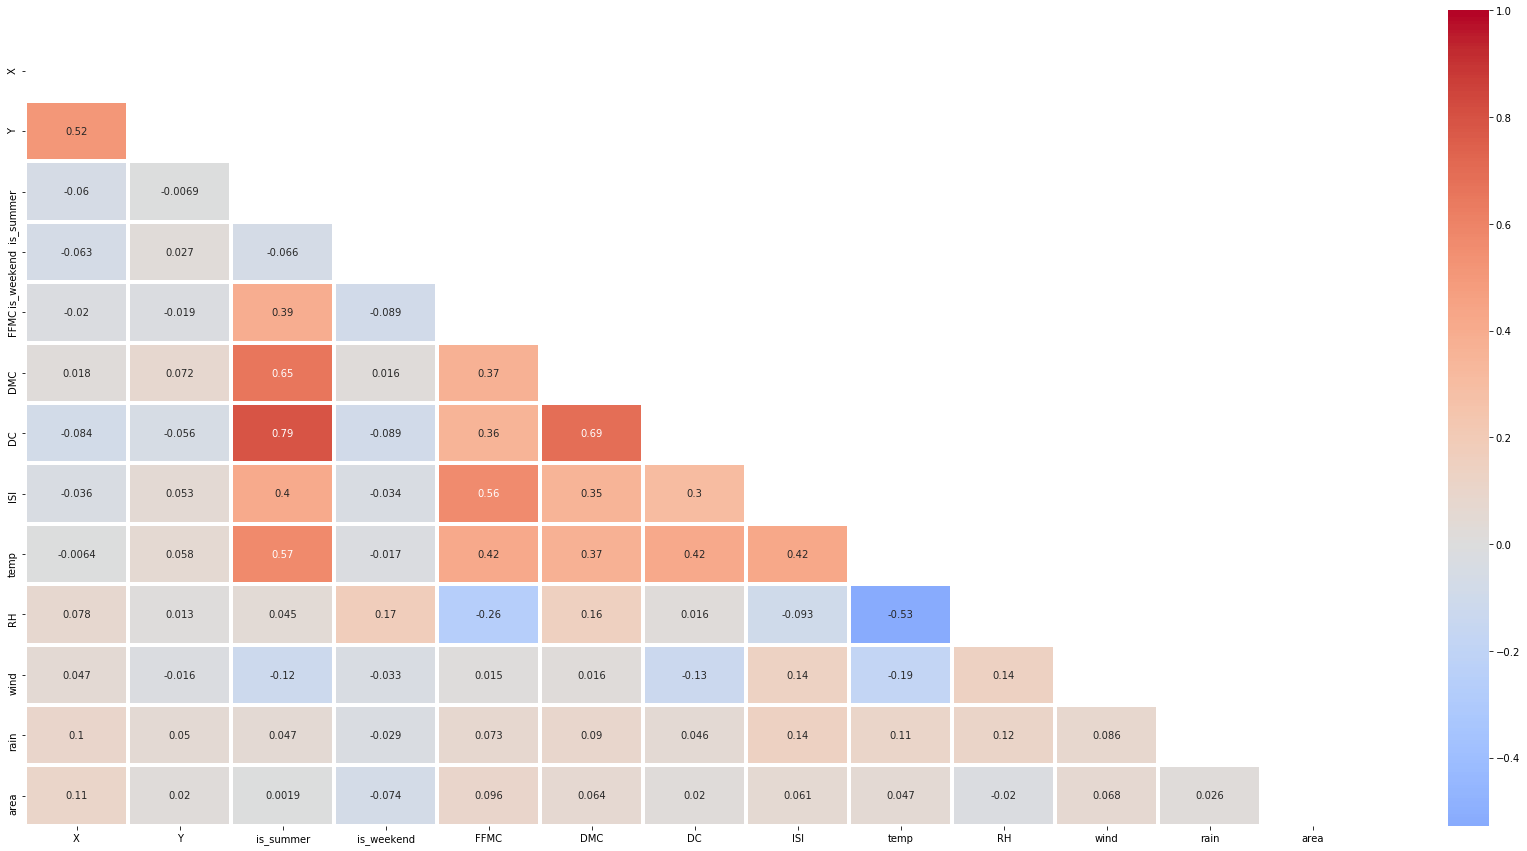

In [7]:
create_corr()

We see that the correlation between wind and area went from 0.065 to 0.068 which is insignificant but better. Let's check to see how the model does (even though the difference is so small that it shouldn't make a noticeable difference).

In [8]:
### testing new model ###

run_model()

For the train set the r2 is: 0.03600046323964401 and the RMSE is: 0.9855583722664809
For the test set the r2 is: -0.04697028521418001 and the RMSE is: 1.023215659191248


The model metrics are slightly worse but likely to be within error. Let's now account for multicollinearity by checking variational influence factors.

In [9]:
# variation inflation factor

# function for VIF
def check_vif():
    vif = pd.Series([variance_inflation_factor(features_train.values, i) 
                   for i in range(features_train.shape[1])], 
                  index = features_train.columns)
    print(vif)

check_vif()

X             1.436186
Y             1.409198
is_summer     4.232285
is_weekend    1.113314
FFMC          1.754038
DMC           2.385113
DC            3.252040
ISI           1.734717
temp          3.344481
RH            2.537820
wind          1.133332
rain          1.109356
dtype: float64


The rule of thumb is that if the VIF of a feature is >5, it suffers from multicollinearity. However, all values are <5 so we should keep them with regards to multicollinearity. Now, in order to improve the metrics for the model, we will start dropping columns that are below a certain threshold of correlation. Initially, we will set the minimum correlation to 0.05.

In [10]:
### dropping columns ###

# columns we will keep
model_columns = ['X', 'is_weekend', 'FFMC', 'DMC', 'ISI', 'wind']

# saving old data just incase
features_train_save = features_train.copy()
features_test_save = features_test.copy()

# revamping
features_train = features_train.loc[:, model_columns]
features_test = features_test.loc[: , model_columns]

In [11]:
### checking new model ###

run_model()

For the train set the r2 is: 0.028691049115701528 and the RMSE is: 0.9892877569511216
For the test set the r2 is: -0.02392974538299608 and the RMSE is: 1.0118941374387915


The metrics have improved slightly. Let's increase the threshold again to 0.7 this time.

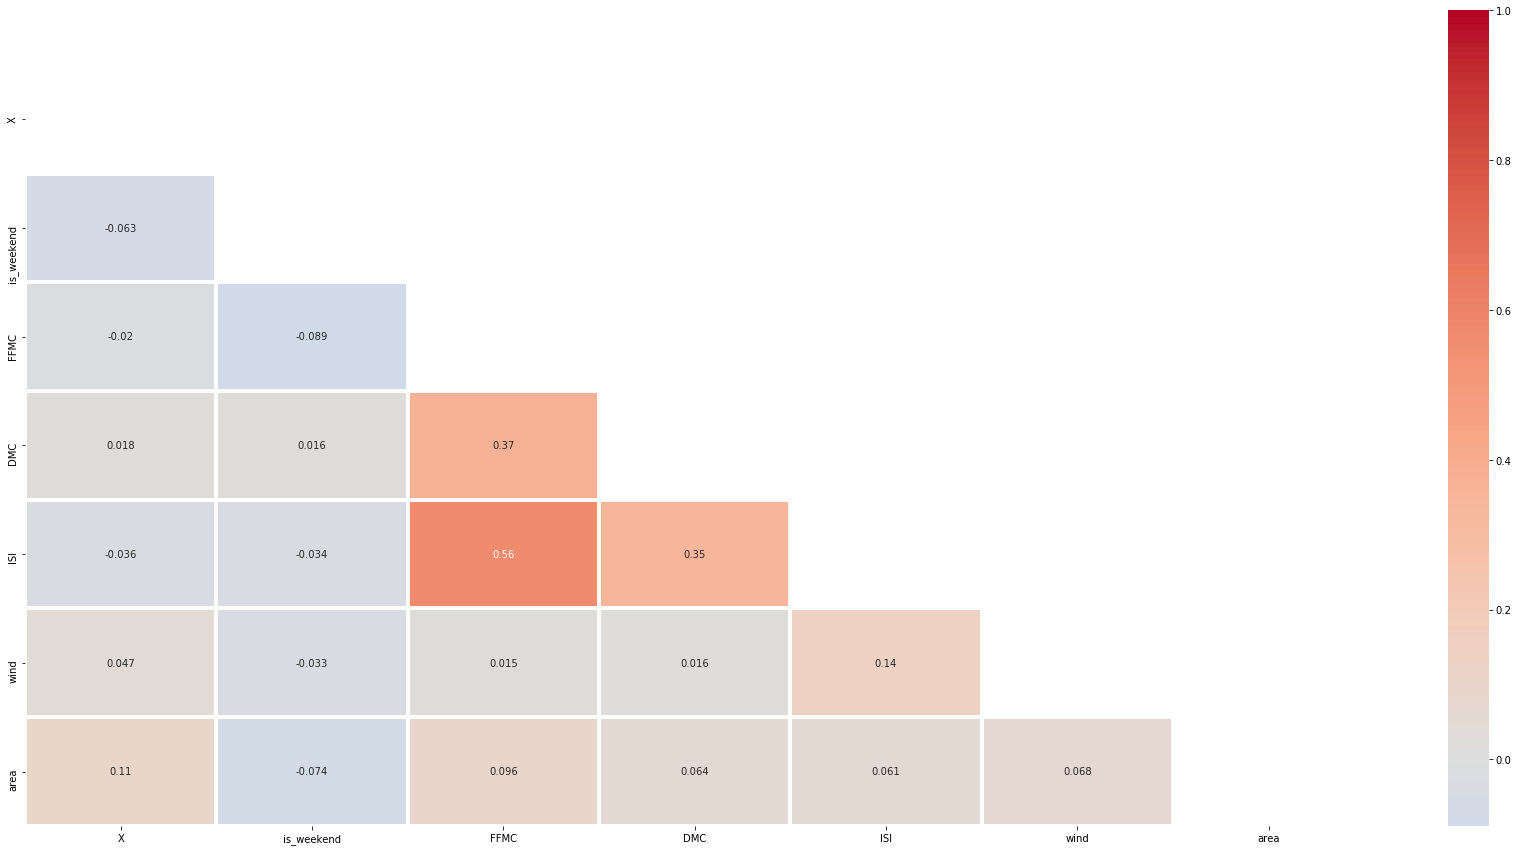

In [12]:
### checking correlations ###

create_corr()

In [13]:
### dropping columns ###

# columns we will keep
model_columns = ['X', 'is_weekend', 'FFMC']

# saving old data just incase
features_train_save = features_train.copy()
features_test_save = features_test.copy()

# revamping
features_train = features_train.loc[:, model_columns]
features_test = features_test.loc[: , model_columns]

In [14]:
### checking new model ###

run_model()

For the train set the r2 is: 0.024228292426541453 and the RMSE is: 0.9915578333035668
For the test set the r2 is: -0.03481926920040901 and the RMSE is: 1.0172606692487471


Dropping the columns did not improve the model. Our best model performance was the one that kept X, is_weekend, FFMC, DMC, ISI, and wind. We will revert to the previous model and perform a k fold cross validation on it to make sure our model is a an accurate fit.

In [25]:
### using best model

# recovering features
features_train = features_train_save
features_test = features_test_save

# creating model
model = LinearRegression().fit(features_train, target_train)

#5 fold cross validation
cross_val = cross_val_score(model, features_test, target_test, cv = 5)

print('The cross val mean is:', np.mean(cross_val), 'and variance is:', np.std(cross_val))

The cross val mean is: -0.0317632043495325 and variance is: 0.07550871134919493


The variance is quite high compared to the accuracy. Either way the model having a negative r2 score means that it is worse than a horizontal line for predictions so will leave it here. We don't believe that we can significantly improve the linear regression model so we will not be checking assumptions such as homoscedasticity.

## Conclusion

Linear regression is not a good model for predicting forest fire area burnt. We will need to use a different model.